## Teleportation using Fusion measurements and feed-forward

In this notebook, we are going to implement a teleportation protocol using a fusion measurement implementing a Bell-basis measurement in the dual rail encoding.

This will showcase how to use the classical control and controlled gates to implement a feed-forward protocol.

### Building blocks

We would like to implement quantum teleportation. In ZX-calculus, we have:

![Snake](./snake.png "Snake equation")

In quantum optics, we can achieve that by using an entangling measurement called a fusion measurement. Fusion measurements are not deterministic, which means that sometimes they fail to introduce entanglement and they can additionally introduce Pauli errors. In practice this means, that we would like to "throw out" the case when a fusion fails and we would like to correct any Pauli errors.

Therefore, we need:
- a fusion measurement: to perform a Bell-basis measurement
- dual-rail encoding of qubits
- a classical protocol to process the measurement results
- a correction of a Pauli error based on the classical protocol
- an entangled Bell pair


### Fusion measurement

Graphically, the fusion measurement we would like to use, takes the following form:

![Fusion II](./fusion_ii.png "Fusion measurement implementing a Bell measurement in dual rail encoding")


where $\underline{a}, \underline{b}, \underline{c}, \underline{d}$ are the measurement outcomes as the measured photon numbers. As we are dealing with dual-rail encoding, we will restrict ourselves to the outcome results where the total measured number of photons is 4. We have that $\underline{s} = \underline{a} \oplus \underline{b}$ is the Boolean value of success (whether an entangling operation succeeded) and $\underline{k} = \underline{s} (\underline{b} + \underline{d}) + \neg \underline s (1 - \frac{\underline{a} + \underline{b}}{2})$ is the Pauli error.
This means that the error is $\underline{b} + \underline{d}$ in case of success and $1 - \frac{\underline{a} + \underline{b}}{2}$ in case of failure.

We interpret this diagram as a CP-map which means that the sums represent classical mixing and not quantum superposition. We obtain different protocols conditioned on the value of $\underline{s}$ and $\underline{k}$.

In our analysis we will ignore the case when the fusion fails.

In [1]:
from optyx.channel import Channel
from optyx.lo import BS_hadamard

from optyx.optyx import (
    DualRail,
    Bit,
    Mode,
    Swap
)

kraus_map_fusion = (
    BS_hadamard @ BS_hadamard >>
    Mode(1) @ Swap(Mode(1), Mode(1)) @ Mode(1) >>
    Mode(1) @ BS_hadamard @ Mode(1) >>
    Swap(Mode(1), Mode(1)) @ Mode(1) @ Mode(1) >>
    Mode(1) @ Swap(Mode(1), Mode(1)) @ Mode(1) >>
    Mode(1) @ Mode(1) @ BS_hadamard
)

fusion = Channel(
    "Fusion",
    kraus_map_fusion
)

### Classical processing of fusion measurement results

In [2]:
from optyx.feed_forward.classical_control import (
    ClassicalFunctionBox,
    ControlChannel
)

def fusion_function(x):
    """
    A classical function that returns two bits based on an input x,
    based on the classical logical for the Fusion type II circuit.
    """
    a = x[0]
    b = x[1]
    c = x[2]
    d = x[3]
    s = (a % 2) ^ (b % 2)
    k = int(s*(b + d) + (1-s)*(1 - (a + b)/2))%2
    return [s, k]

classical_function = ControlChannel(
    ClassicalFunctionBox(
        fusion_function,
        Mode(4),
        Bit(2)
    )
)

### Corrections

We would like to ignore the failure case (which is a simplification). We will simply postselect on the case of success.

In [3]:
from optyx.feed_forward.controlled_gates import BitControlledBox
from optyx.zx import X
from optyx.optyx import Scalar

postselect_1 = postselect_1 = X(1, 0, 0.5) @ Scalar(0.5**0.5)

from optyx.channel import (
    bit,
    qmode
)

fusion_failure_processing = ControlChannel(
    postselect_1
)

To correct the Pauli error on the success case, we need to introduce a Phase shift in dual rail encoding:

![Phase](./phase_correction.png "Phase correction")

The application of this gate is condition on the results of the classical processing of the measurement results. In particular, we want to apply the gate if $\underline{k}$ is 1.

In [12]:
from optyx.lo import Phase

# apply the box if the control bit is 1, otherwise apply an identity channel
correction = Channel(
    "Phase Correction",
    BitControlledBox(
        BS_hadamard >> (Phase(0.5) @ Mode(1)) >> BS_hadamard
    ),
    dom = bit @ qmode**2
)

### Putting it all together

We simplify the overall protocol by assuming we have an access to a dual-rail encoded Bell pair available to both parties partaking in the protocol:

In [13]:
from optyx.zx import Z
from optyx.zw import Scalar

channel_bell = Channel(
    "Bell pair preparation",
    Z(0, 2) @ Scalar(0.5**0.5) >> DualRail() @ DualRail()
)

dual_rail_input = Channel(
    "Dual rail of input",
    DualRail()
)

In [14]:
from optyx.channel import Measure

teleportation = (
    dual_rail_input @ channel_bell >>
    fusion @ qmode**2 >>
    Measure(qmode**4) @ qmode**2 >>
    classical_function @ qmode**2 >>
    fusion_failure_processing @ correction >>
    Channel("Dual rail projection", DualRail().dagger())
)

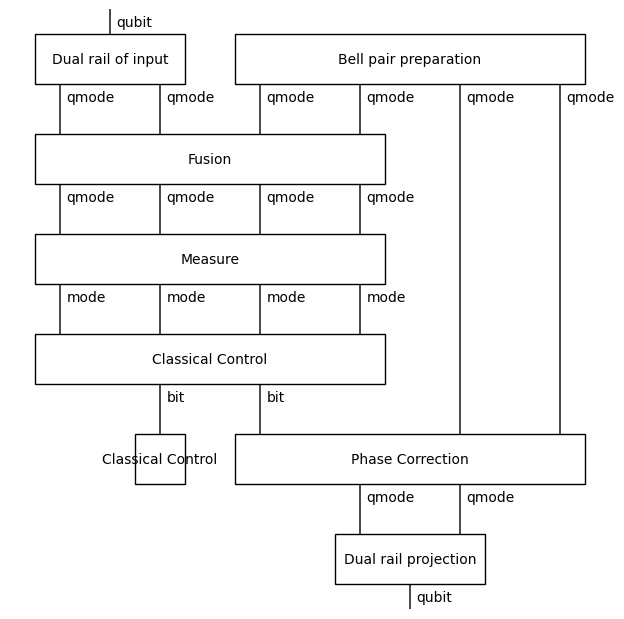

In [15]:
teleportation.foliation().draw()

In [16]:
array_teleportation = teleportation.double().to_zw().to_tensor().eval().array

The protocol should implement an identity channel with scalar of $\frac{1}{2}$:

In [17]:
from optyx.optyx import Id

array_id = Channel(
    "Identity",
    Id(Bit(1)) @ Scalar(0.5**0.5)
).double().to_zw().to_tensor().eval().array

In [18]:
import numpy as np

np.allclose(array_teleportation, array_id)

True